In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from convnwb.io import load_nwbfile,make_session_name
from spiketools.measures.spikes import compute_firing_rate
from spiketools.plts.spatial import plot_position_by_time, plot_position_1d, plot_positions, plot_heatmap,create_heatmap_title
from spiketools.plts.spikes import plot_firing_rates
from spiketools.plts.trials import plot_rasters

from spiketools.plts.data import plot_bar, plot_hist, plot_text, plot_barh,plot_lines
from spiketools.plts.utils import make_axes
from spiketools.plts.annotate import add_hlines, add_vlines

from spiketools.utils.timestamps import convert_sec_to_min, sum_time_ranges
from spiketools.utils.extract import get_range, get_value_by_time, get_values_by_time_range, drop_range
from spiketools.utils.epoch import epoch_data_by_range
from spiketools.utils.data import compute_range
from spiketools.utils.base import count_elements
from spiketools.plts.utils import make_grid, get_grid_subplot

from spiketools.utils.timestamps import convert_sec_to_min
from spiketools.spatial.occupancy import compute_occupancy

In [3]:
# Local imports
import sys
sys.path.append('../code')
from plts import plot_task_structure,plot_positions_with_speed
from utils import group_array_by_key
from reports import create_sess_str

# Settings

In [4]:
base_path = "/Users/weijiazhang/Data/Train/nwbfiles"

In [5]:
session = {
    'experiment' : 'TRAIN',
    'subject' : 'UT048',
    'session' : '0'    
}

In [6]:
experiment = session['experiment']
subject = session['subject']
sess = session['session']
session_name = make_session_name(subject,experiment,sess)
session_name

'TRAIN_UT048_session_0'

# Load Data 

In [7]:
# Load NWB file
nwbfile = load_nwbfile(session, base_path)

/Users/weijiazhang/anaconda3/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/Users/weijiazhang/anaconda3/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.5.0 is already loaded.
  return func(args[0], **pargs)
/Users/weijiazhang/anaconda3/lib/python3.11/site-packages/pynwb/base.py:195: UserWarning: Timeseries has a rate of 0.0 Hz, but the length of the data is greater than 1.
  warn('Timeseries has a rate of 0.0 Hz, but the length of the data is greater than 1.')


# Task Structure 
In the following, lines and colors means shadings are:

- trial start: red line 
- trial end: black line (in some trials, black line can be trial start and trial end) 
- response time: grey line
- hold period: green 
- movement period: orange 
- fixation period: purple 
- feed back period: blue

In [9]:
# Get the number of trials 
n_trials = len(nwbfile.trials)
print('Number of trials: {}'.format(n_trials))
session['n_trials'] = n_trials

Number of trials: 64


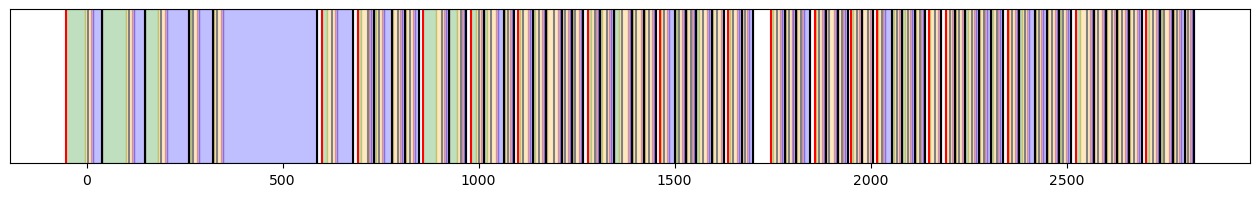

In [10]:
# Plot the task structure for the whole recording 
plot_task_structure(nwbfile.trials)

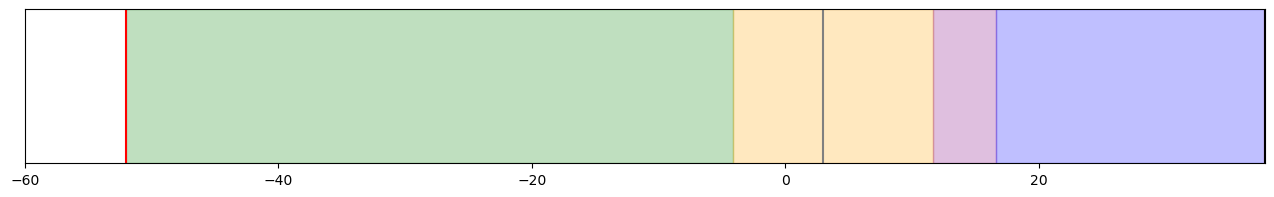

In [11]:
# Plot the task structure for 1 trial
plot_task_structure(nwbfile.trials, xlim=[-60, nwbfile.trials.stop_time[0]])

In [12]:
# Check task time range 
task_range = [nwbfile.trials.start_time[0], nwbfile.trials.stop_time[-1]]

# Compute the task length, in minutes
task_len = convert_sec_to_min(task_range[1])

# Check the task / recording length, based on unit time
print('Task length: {:1.2f} minutes'.format(task_len))
session['task_length'] = np.round(task_len,2)

Task length: 47.07 minutes


## General Checks 

### Positions

In [13]:
# Grab the position data
pos = nwbfile.acquisition['position']['player_position']
ptimes = pos.timestamps[:]
positions = pos.data[:]

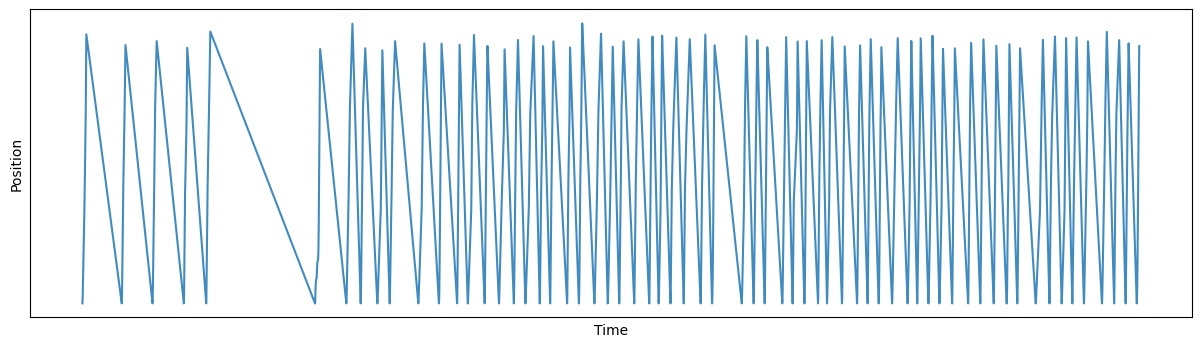

In [14]:
# Plot position across time
plot_position_by_time(pos.timestamps[:], pos.data[:], alpha=0.85, figsize=(15, 4))

### Speed 

Text(0, 0.5, 'Frequency')

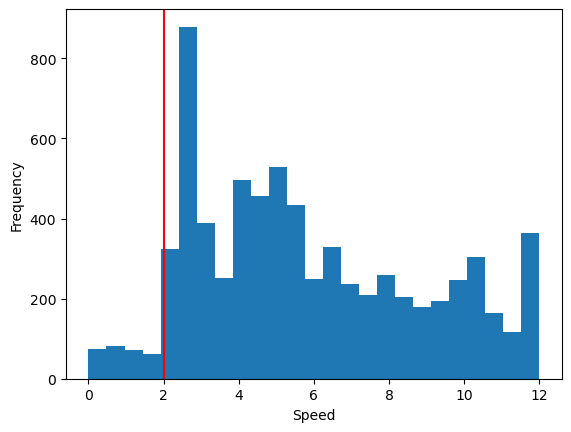

In [15]:
speed_thresh = 2
speed = nwbfile.processing['position_measures']['speed'].data[:]
plot_hist(speed, bins=25)
add_vlines(speed_thresh, color='red')
plt.xlabel('Speed')
plt.ylabel('Frequency')

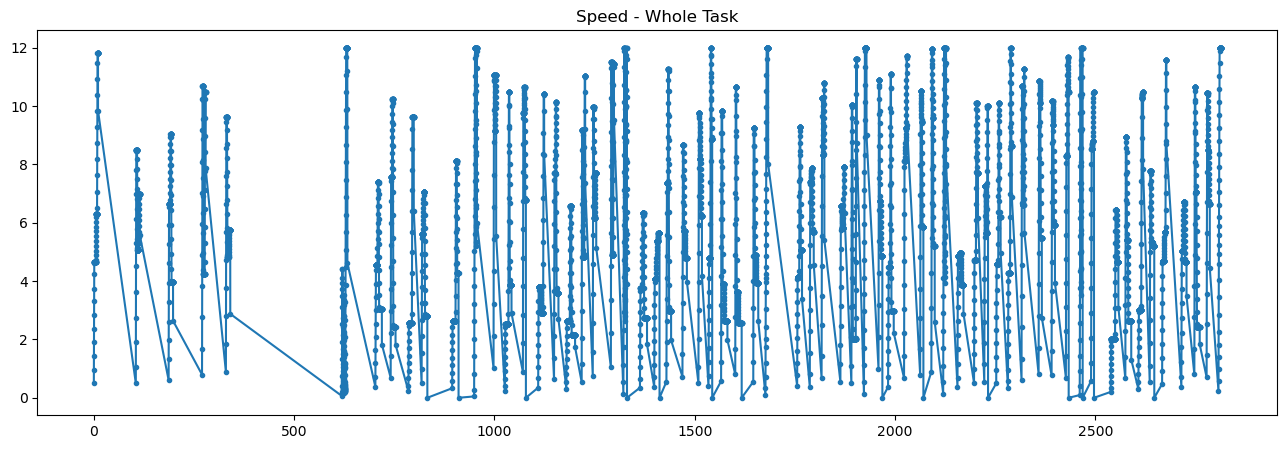

In [16]:
# Plot the speed across the whole task
plot_lines(ptimes, speed, marker='.', title='Speed - Whole Task', figsize=(16, 5))

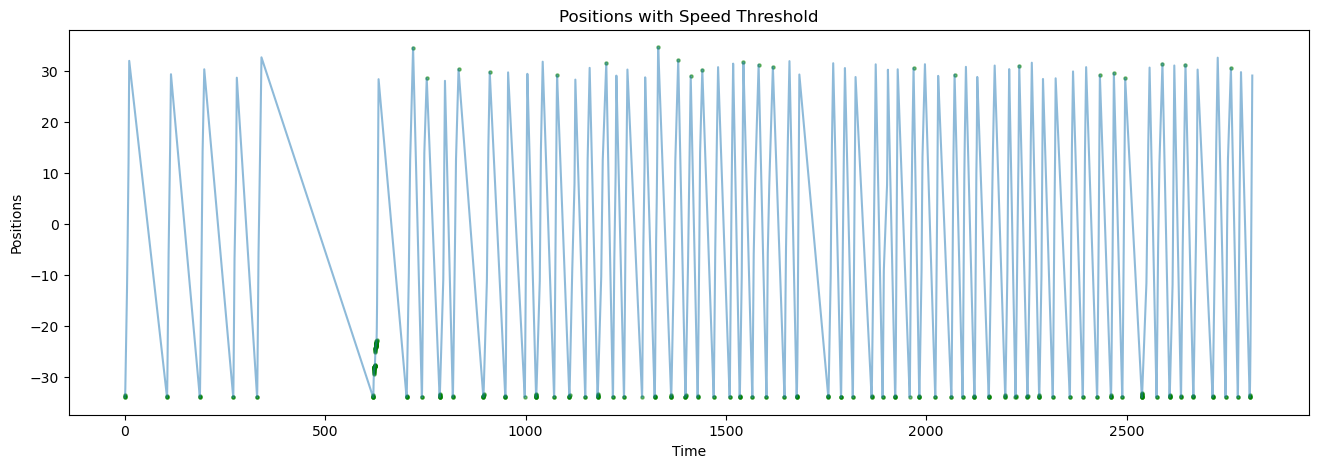

In [17]:
plot_positions_with_speed(ptimes, positions, speed,speed_thresh)

### Occupancy 

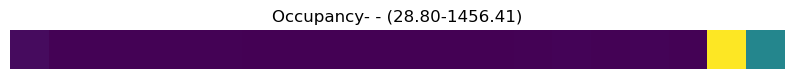

In [18]:
time_thresh = 0.1
min_occ = 0
num_bins = 20

# Compute occupancy values
occ = compute_occupancy(positions, ptimes, bins = num_bins)

# Plot the occupancy
plot_heatmap(occ, title=create_heatmap_title('Occupancy-',occ), figsize=(10, 5))

### Check for object locations 

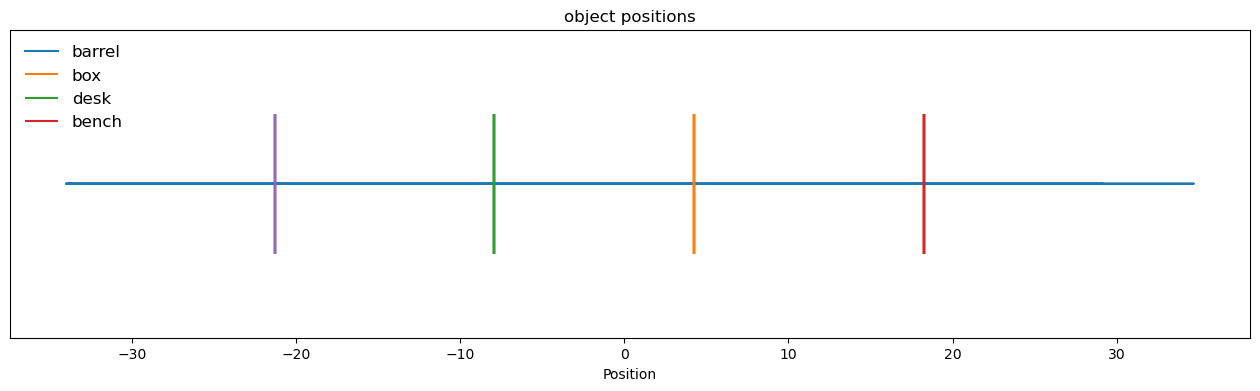

In [19]:
obj_pos = nwbfile.trials['object_position'].data[:]
obj = nwbfile.trials['object'].data[:]


obj_res = group_array_by_key(obj, obj_pos)
obj_barrel = np.array(obj_res ['barrel'][:])
obj_box = np.array(obj_res ['box'][:])
obj_desk = np.array(obj_res ['desk'][:])
obj_bench = np.array(obj_res ['bench'][:])
plot_position_1d(positions, [obj_barrel,obj_box,obj_desk,obj_bench], figsize=(16, 4))
plt.title('object positions')
plt.legend(['barrel', 'box', 'desk', 'bench'], loc='upper left', frameon=False, fontsize='large')


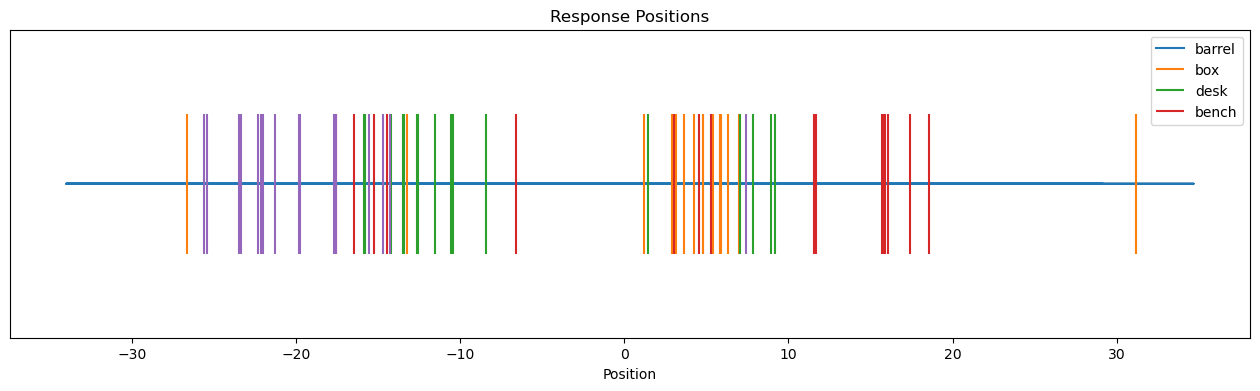

In [20]:
res_pos = nwbfile.trials['response_position'].data[:]
result_res = group_array_by_key(obj, res_pos)
res_barrel = np.array(result_res ['barrel'][:])
res_box = np.array(result_res ['box'][:])
res_desk = np.array(result_res ['desk'][:])
res_bench = np.array(result_res ['bench'][:])
plot_position_1d(positions, [res_barrel, res_box, res_desk, res_bench],
                 title='Response Positions', legend=['barrel','box','desk','bench'], figsize=(16, 4))

### Check for response error

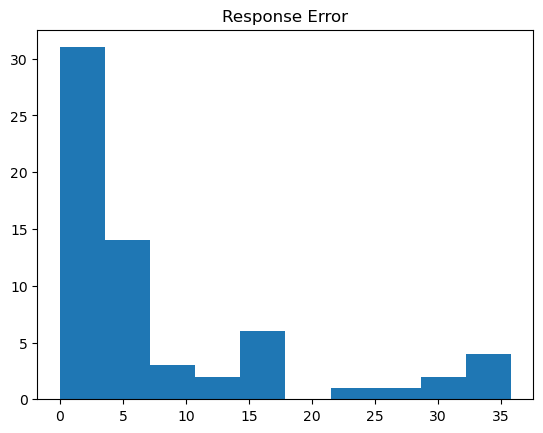

In [21]:
# plot response error
plot_hist(nwbfile.trials['response_error'].data[:], title='Response Error')

# Check Unit Data 

In [22]:
# Check how many units are available
n_units = len(nwbfile.units)
print('Number of unit: {}'.format(n_units))
session['n_units'] = n_units

Number of unit: 15


In [23]:
# Check the total number of spikes
print('Total number of spikes: {}'.format(nwbfile.units.spike_times.shape[0]))

Total number of spikes: 284281


In [24]:
# Get spiking activity from across all units
all_spikes = [nwbfile.units.get_unit_spike_times(uind) for uind in range(n_units)]

In [25]:
# Calculate the average overall firing rate of each neuron
rates = [compute_firing_rate(spikes) for spikes in all_spikes]

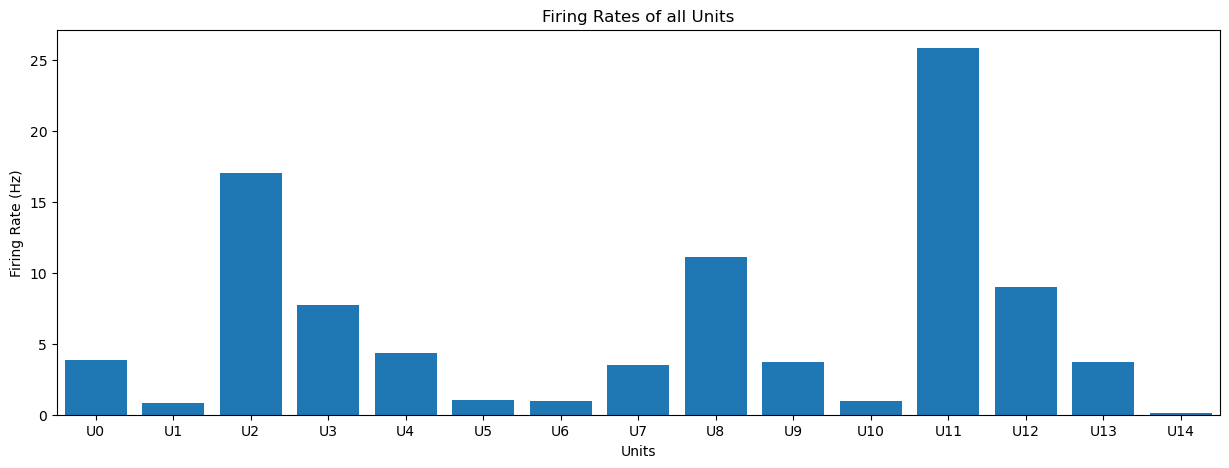

In [26]:
# Plot approximate firing rate for each unit
plot_firing_rates(rates, figsize=(15, 5))

# Create Session Reposrt 

In [27]:
session

{'experiment': 'TRAIN',
 'subject': 'UT048',
 'session': '0',
 'n_trials': 64,
 'task_length': 47.07,
 'n_units': 15}

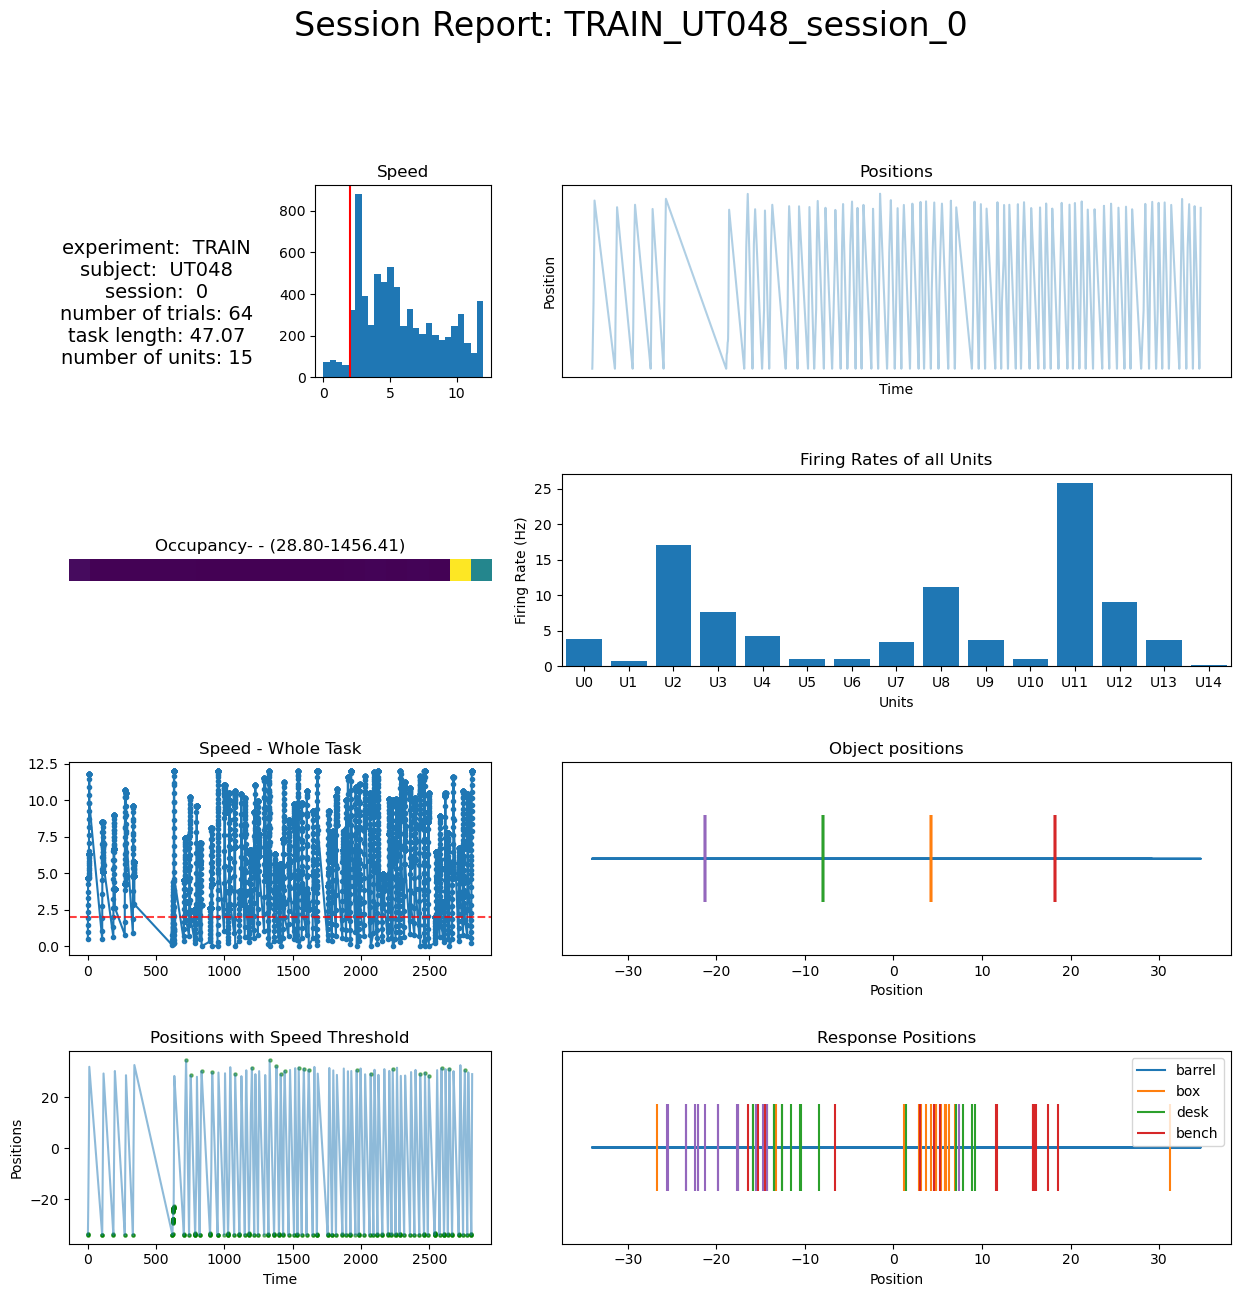

In [28]:
# Initialize figure with grid layout
grid = make_grid(7, 5, wspace=0.4, hspace=0.5, figsize=(15, 25),
                 width_ratios=[0.7, 0.7, 0.7, 0.7, 0.7],
                 title=f'Session Report: {session_name}')
plot_text(create_sess_str(session), ax=get_grid_subplot(grid, 0, 0))
plot_heatmap(occ, title=create_heatmap_title('Occupancy-',occ), ax=get_grid_subplot(grid, slice(1,2), slice(0, 2)))
plot_position_by_time(ptimes,positions,ax=get_grid_subplot(grid, slice(0, 1), slice(2, 5)))
plt.title('Positions')

plot_firing_rates(rates, ax = get_grid_subplot(grid, slice(1, 2), slice(2, 5)))

plot_position_1d(positions, [obj_barrel,obj_box,obj_desk,obj_bench],ax = get_grid_subplot(grid, slice(2, 3), slice(2, 5)))
plt.title('Object positions')

plot_position_1d(positions, [res_barrel, res_box, res_desk, res_bench],
                 title='Response Positions', legend=['barrel','box','desk','bench'], ax = get_grid_subplot(grid, slice(3, 4), slice(2, 5)))

plot_hist(speed, bins=25,ax=get_grid_subplot(grid, 0,1))
add_vlines(speed_thresh, color='red')
plt.title('Speed')

plot_lines(ptimes, speed, marker='.', title='Speed - Whole Task',ax=get_grid_subplot(grid, slice(2,3), slice(0, 2)))
add_hlines(speed_thresh, color='red', alpha=0.75, linestyle='--')
plot_positions_with_speed(ptimes, positions, speed,speed_thresh, ax=get_grid_subplot(grid, slice(3,4), slice(0, 2)))
